# ScaffoldGraph: Scaffold networks and trees

ScaffoldGraph can generate scaffold networks and scaffold trees from SDF and SMILES files.

This simple guide aims to show the very basics of what can be done with ScaffoldNetworks and ScaffoldTrees using ScaffoldGraph, RDKit and the NetworkX API.

In [2]:
# Import scaffoldgraph
import scaffoldgraph as sg

# Import networkx
import networkx as nx

# Import plotting tools
import matplotlib.pyplot as plt

# Import rdkit
from rdkit.Chem import Draw
from rdkit import Chem

import random
import os

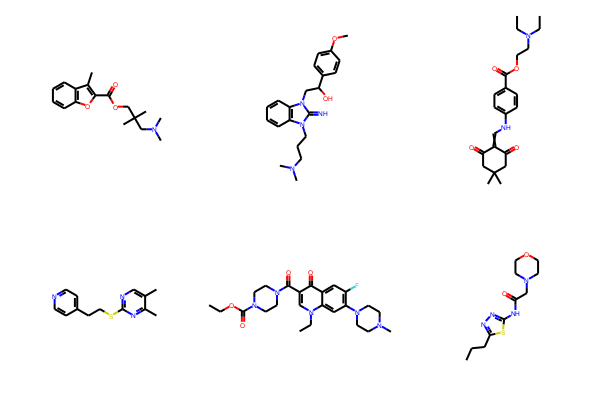

In [3]:
# Visualize some molecules in the example SDF file

sdf_file = os.path.dirname(sg.__file__).replace('scaffoldgraph', 'examples/example.sdf') # Example SDF file (200 PubChem compounds)
supplier = Chem.SDMolSupplier(sdf_file)

peek = 6
Draw.MolsToGridImage([supplier[x] for x in range(peek)])

## Scaffold Networks

Scaffold networks can be generated using the sg.ScaffoldNetwork class

* sg.ScaffoldNetwork.from_sdf(*args, **kwargs)
* sg.ScaffoldNetwork.from_smiles_file(*args, **kwargs)
* sg.Scaffoldnetwork.from_supplier(*args, **kwargs) (custom molecule supplier)

In this guide we will be working with molecules in examples.sdf

#### Note:

The ScaffoldNetwork generator breaks fused ring systems as per the definition in the original publication. If the user wants to preserve fused ring systems then they should use the sg.HierS class which functions in the same way as the ScaffoldNetwork class but does not break fused ring systems. 


In [4]:
# We can generate a scaffold network from this SDF file
# The progress flag tracks the progress of the operation with a progress bar

network = sg.ScaffoldNetwork.from_sdf(sdf_file, progress=True)

# We can access the number of molecule nodes and scaffold nodes in the graph
n_scaffolds = network.num_scaffold_nodes
n_molecules = network.num_molecule_nodes

print('\nGenerated scaffold network from {} molecules with {} scaffolds\n'.format(n_molecules, n_scaffolds))

ScaffoldNetwork: 200it [00:01, 121.70it/s]                         



Generated scaffold network from 199 molecules with 805 scaffolds



['c1ccc2occc2c1', 'c1ccccc1', 'c1ccoc1', 'N=c1[nH]c2ccccc2n1CCc1ccccc1', 'N=c1[nH]ccn1CCc1ccccc1']


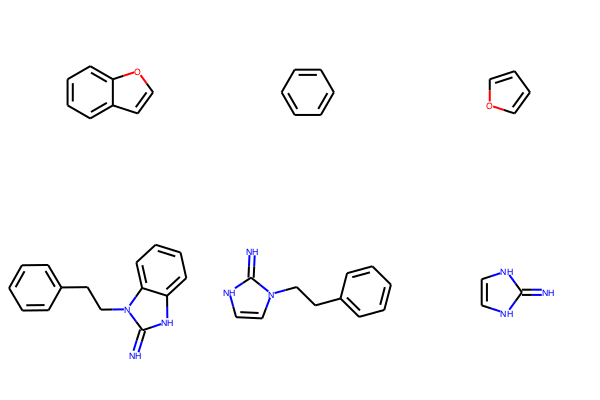

In [5]:
# We can obtain a list of SMILES strings representing scaffolds in the scaffold network

scaffolds = list(network.get_scaffold_nodes())
print(scaffolds[0:5])

# Visualize a few of the scaffolds

sample = 6
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in scaffolds[:sample]])

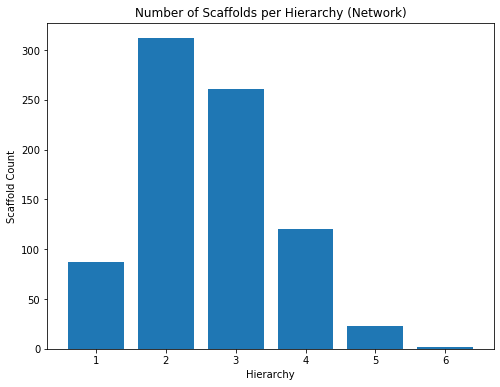

In [6]:
# We can get the number of scaffolds in each hierarchy easily

counts = network.get_hierarchy_sizes()  # returns a collections Counter object
lists = sorted(counts.items())
x, y = zip(*lists)

# Plot sizes as bar chart

plt.figure(figsize=(8, 6))
plt.bar(x, y)
plt.xlabel('Hierarchy')
plt.ylabel('Scaffold Count')
plt.title('Number of Scaffolds per Hierarchy (Network)')
plt.show()

['6603170', '6602966', '6602949', '6602842', '6602774', '6602679'] 

6602842 : Cc1cnc(SCCc2ccncc2)nc1C


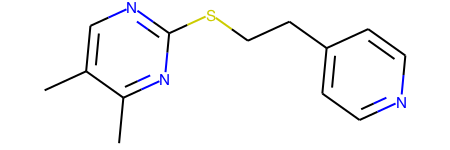

In [7]:
# Molecules are stored in the network with their _Name property as a key
# When using SDF format rdkit assigns the _Name property from the TITLE section
# In this case this refers to a PubChem ID

molecules = list(network.get_molecule_nodes())
print(molecules[0:6], '\n')

# The SMILES strings for these molecules are accessible in the nodes attributes

mol_id = 3
pubchem_id = molecules[mol_id]
smiles = network.nodes[pubchem_id]['smiles']

print('{} : {}'.format(pubchem_id, smiles))
Chem.MolFromSmiles(smiles)

['6602842', 'c1cnc(SCCc2ccncc2)nc1', 'c1ccncc1', 'c1cncnc1']


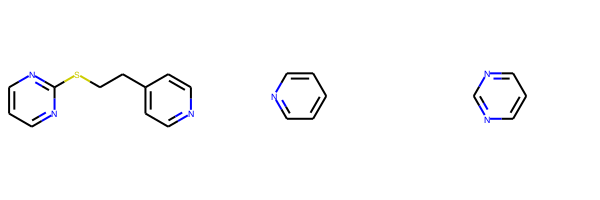

In [8]:
# Using the NetworkX API it is easy to find subscaffolds for a molcule of interest.
# We can use a breadth first search to find subscaffolds of the above molecule example.
# Scaffolds are predecessors of molecules as they form the molecules building blocks.

predecessors = list(nx.bfs_tree(network, pubchem_id, reverse=True))
print(predecessors)  # entry [0] is the search molecule 
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in predecessors[1:]])


Found 27 scaffolds in hierarchy 2 containing c1ccncc1:


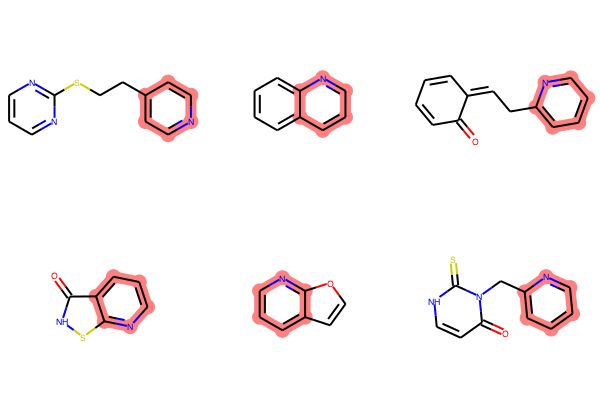

In [9]:
# Just as we can find subscaffolds of a molecule we can find larger scaffolds and molecules from subscaffolds

query_smiles = 'c1ccncc1'  # lets use this subscaffold as a query
query_mol = Chem.MolFromSmiles(query_smiles)

# First lets find scaffolds in the above hierarchy (-> 2)
# We can differentiate molecules from scaffolds using the node 'type' attribute
# scaffold nodes have type: 'scaffold' whereas molecules have type: 'molecule'

next_scaffolds = []
for succ in network.successors(query_smiles):
    if network.nodes[succ]['type'] == 'scaffold':
        next_scaffolds.append(succ)

print('Found {} scaffolds in hierarchy 2 containing {}:'.format(len(next_scaffolds), query_smiles))

mols = [Chem.MolFromSmiles(x) for x in next_scaffolds[:6]]
Draw.MolsToGridImage(mols, highlightAtomLists=[mol.GetSubstructMatch(query_mol) for mol in mols])


Found 28 molecules containing scaffold, c1ccncc1



/Users/oliverscott/miniconda3/envs/ScaffoldGraph/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 9. Change the maxMols value to display more.
  % (maxMols))


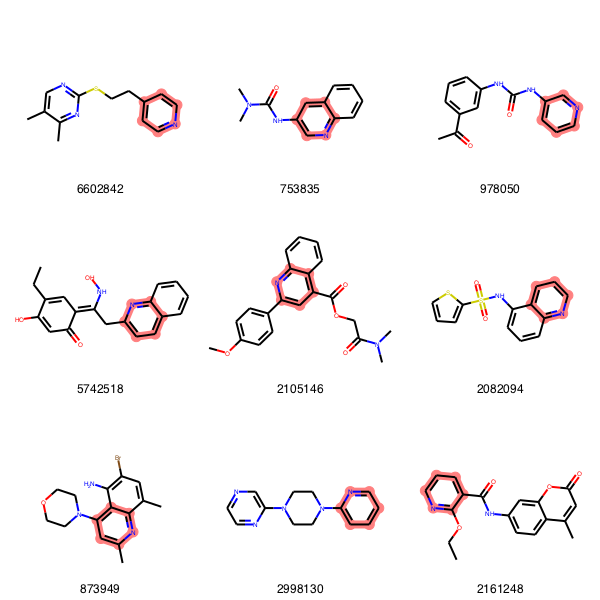

In [10]:
# Lets try the same thing but for molecules

molecules = []
for succ in nx.bfs_tree(network, query_smiles, reverse=False):
    if network.nodes[succ]['type'] == 'molecule':
        molecules.append(succ)

print('Found {} molecules containing scaffold, {}\n'.format(len(molecules), query_smiles))

# Molecules are PubChem IDs so lets get the SMILES and view som of the molecules

smiles = [network.nodes[pid]['smiles'] for pid in molecules]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]

Draw.MolsToGridImage(mols, highlightAtomLists=[mol.GetSubstructMatch(query_mol) for mol in mols],
                    legends=molecules, maxMols=9)


## Scaffold Trees

Scaffold trees can be generated using the sg.ScaffoldTree class

* sg.ScaffoldTree.from_sdf(*args, **kwargs)
* sg.ScaffoldTree.from_smiles_file(*args, **kwargs)
* sg.ScaffoldTree.from_supplier(*args, **kwargs) (custom molecule supplier)

In this guide we will be working with molecules in examples.sdf

All the examples above can also be applied to the tree structure


In [11]:
# We can generate a scaffold tree from the SDF file just like before

tree = sg.ScaffoldTree.from_sdf(sdf_file, progress=True)

# We can access the number of molecule nodes and scaffold nodes in the graph
n_scaffolds = tree.num_scaffold_nodes
n_molecules = tree.num_molecule_nodes

print('\nGenerated scaffold tree from {} molecules with {} scaffolds\n'.format(n_molecules, n_scaffolds))

# The output is a forest structure (multiple trees)

print('Graph is a Forest:', nx.is_forest(tree))


ScaffoldTree: 200it [00:01, 143.14it/s]                         



Generated scaffold tree from 199 molecules with 450 scaffolds

Graph is a Forest: True


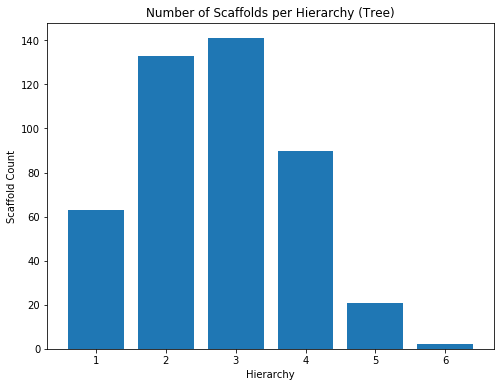

In [12]:
# We can get the number of scaffolds in each hierarchy easily (The numbers are different to the network)

counts = tree.get_hierarchy_sizes()
lists = sorted(counts.items())
x, y = zip(*lists)

# Plot sizes as bar chart

plt.figure(figsize=(8, 6))
plt.bar(x, y)
plt.xlabel('Hierarchy')
plt.ylabel('Scaffold Count')
plt.title('Number of Scaffolds per Hierarchy (Tree)')
plt.show()

PubChem ID: 722911
Predecessors of 722911 is Tree: True


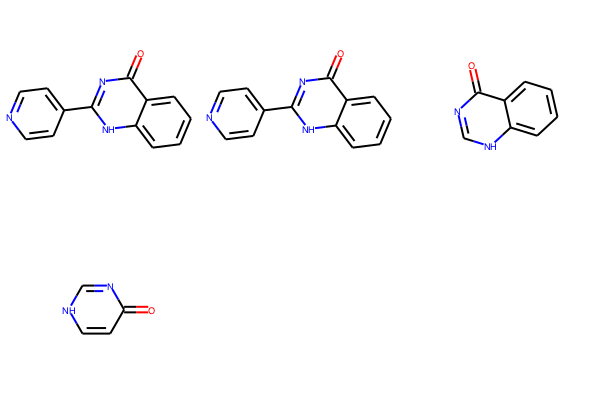

In [13]:
# We can choose a random molecule in the set and view its scaffold predecessors

random_pubchem_id = random.choice(list(tree.get_molecule_nodes()))
print('PubChem ID:', random_pubchem_id)
predecessors = nx.bfs_tree(tree, random_pubchem_id, reverse=True)

# We can validate that one molecules scaffold set forms a tree structure

print('Predecessors of {} is Tree: {}'.format(random_pubchem_id, nx.is_tree(predecessors)))

# Draw these scaffolds

predecessors_list = list(predecessors)
predecessors_list[0] = tree.nodes[predecessors_list[0]]['smiles'] # [0] is pubchem ID
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in predecessors_list])